# Introduction 

The goal of this analysis is to create a classification model that predicts if a player will be drafted in the first round of the NHL draft based on statisitcs from their junior hockey career. 

THe data comes from the following two sources:

NHL Draft Data: `https://www.kaggle.com/datasets/mattop/nhl-draft-hockey-player-data-1963-2022`

Amateur Hockey Data: `https://www.kaggle.com/datasets/mjavon/elite-prospects-hockey-stats-player-data`
Note, use the `player_stats` file

In [154]:
#Import standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

## Exploring the Data

In [155]:
#Lets load the dataset for the NHL Draft Picks
df=pd.read_csv('nhldraft.csv')
df.head()


,id,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,...,points,plus_minus,penalties_minutes,goalie_games_played,goalie_wins,goalie_losses,goalie_ties_overtime,save_percentage,goals_against_average,point_shares
0,1,2022,1,Montreal Canadiens,Juraj Slafkovsky,SK,LW,18.0,NaN,TPS (Finland),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2022,2,New Jersey Devils,Simon Nemec,SK,D,18.0,NaN,HK Nitra (Slovakia),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2022,3,Arizona Coyotes,Logan Cooley,US,C,18.0,NaN,USA U-18 Development Team (USDP/USHL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2022,4,Seattle Kraken,Shane Wright,CA,C,18.0,NaN,Kingston Frontenacs (OHL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2022,5,Philadelphia Flyers,Cutter Gauthier,SE,LW,18.0,NaN,USA U-18 Development Team (USDP/USHL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
#Immediately, lets drop all columns that are not needed
df.drop(columns={ 'to_year', 'games_played', 'goals',
       'assists', 'points', 'plus_minus', 'penalties_minutes',
       'goalie_games_played', 'goalie_wins', 'goalie_losses',
       'goalie_ties_overtime', 'save_percentage', 'goals_against_average',
       'point_shares'},inplace=True)

In [157]:
junior_data=pd.read_csv('player_stats.csv',encoding='ISO-8859-1')
junior_data.head()

,ROW_ID,PLAYER_URL,PLAYER_ID,PLAYER_NAME,FIRST_NAME,LAST_NAME,PRIMARY_POS,SECONDARY_POS,G,A,GP,PIM,+/-,LEAGUE,LEAGUE_YEAR,P,PPG
0,1,https://www.eliteprospects.com/player/9678/way...,9678.0,Wayne Gretzky (C),Wayne,Gretzky,C,NaN,92.0,120.0,80.0,26.0,80.0,NHL,1981-1982,212.0,2.6500
1,2,https://www.eliteprospects.com/player/21408/mi...,21408.0,Mike Bossy (RW),Mike,Bossy,RW,NaN,64.0,83.0,80.0,22.0,69.0,NHL,1981-1982,147.0,1.8375
2,3,https://www.eliteprospects.com/player/21343/pe...,21343.0,Peter Stastny (C),Peter,Stastny,C,NaN,46.0,93.0,80.0,91.0,-10.0,NHL,1981-1982,139.0,1.7375
3,4,https://www.eliteprospects.com/player/42478/de...,42478.0,Dennis Maruk (C),Dennis,Maruk,C,NaN,60.0,76.0,80.0,128.0,-4.0,NHL,1981-1982,136.0,1.7000
4,5,https://www.eliteprospects.com/player/22541/br...,22541.0,Bryan Trottier (C),Bryan,Trottier,C,NaN,50.0,79.0,80.0,88.0,70.0,NHL,1981-1982,129.0,1.6125


I will explore the junior dataset first because I need to merge it to the draft picks dataset to populate the player stats

In [158]:
#Lets create a new column for the name. This will be the key to join the datasets. I will also drop all unnecessary columns
junior_data['player']=junior_data.FIRST_NAME + " " + junior_data.LAST_NAME
junior_data.drop(columns={'ROW_ID','PLAYER_URL','PLAYER_ID','PLAYER_NAME','SECONDARY_POS','PRIMARY_POS','FIRST_NAME','LAST_NAME'},inplace=True)
junior_data.head()

,G,A,GP,PIM,+/-,LEAGUE,LEAGUE_YEAR,P,PPG,player
0,92.0,120.0,80.0,26.0,80.0,NHL,1981-1982,212.0,2.6500,Wayne Gretzky
1,64.0,83.0,80.0,22.0,69.0,NHL,1981-1982,147.0,1.8375,Mike Bossy
2,46.0,93.0,80.0,91.0,-10.0,NHL,1981-1982,139.0,1.7375,Peter Stastny
3,60.0,76.0,80.0,128.0,-4.0,NHL,1981-1982,136.0,1.7000,Dennis Maruk
4,50.0,79.0,80.0,88.0,70.0,NHL,1981-1982,129.0,1.6125,Bryan Trottier


In [159]:
#I will explore Craig Rivet stats as a case study
junior_data[junior_data.player=='Craig Rivet']

,G,A,GP,PIM,+/-,LEAGUE,LEAGUE_YEAR,P,PPG,player
9233,0.0,1.0,5.0,5.0,2.0,NHL,1994-1995,1.0,0.200000,Craig Rivet
9894,1.0,4.0,19.0,54.0,4.0,NHL,1995-1996,5.0,0.263158,Craig Rivet
10700,0.0,4.0,35.0,54.0,7.0,NHL,1996-1997,4.0,0.114286,Craig Rivet
11520,0.0,2.0,61.0,93.0,-3.0,NHL,1997-1998,2.0,0.032787,Craig Rivet
12093,2.0,8.0,66.0,66.0,-3.0,NHL,1998-1999,10.0,0.151515,Craig Rivet
12848,3.0,14.0,61.0,76.0,11.0,NHL,1999-2000,17.0,0.278689,Craig Rivet
13991,1.0,2.0,26.0,36.0,-8.0,NHL,2000-2001,3.0,0.115385,Craig Rivet
14477,8.0,17.0,82.0,76.0,1.0,NHL,2001-2002,25.0,0.304878,Craig Rivet
15385,7.0,15.0,82.0,71.0,1.0,NHL,2002-2003,22.0,0.268293,Craig Rivet
16423,4.0,8.0,80.0,98.0,-1.0,NHL,2003-2004,12.0,0.150000,Craig Rivet


For this example, we only want the OHL data. We also have three seasons. We could either take the most recent season or an average of all seasons.
Because the most recent season often is the most important for the draft year, we will only keep the most recent season.

First, lets filter out att data that is not junior level. Lets look at the types of leagues

In [160]:
junior_data.LEAGUE.unique()

array(['NHL', 'AHL', 'ECHL', 'NCAA', 'KHL', 'USHL', 'WHL', 'BCHL', 'OHL',
       'QMJHL', 'AJHL', 'MJHL', 'SIJHL', 'SJHL', 'CCHL', 'NOJHL', 'OJHL',
       'MJAHL', 'QJAAAHL', 'SHL', 'LIIGA', 'NLA', 'DEL', 'CZECH',
       'USHS-PREP', 'USHS-MN', 'USHS-MI', 'USHS-NY', 'USHS-MA'],
      dtype=object)

In [161]:
#These are all of the junior leagues that we will keep
junior_leagues=['NCAA','USHL','WHL','BCHL','OHL','QMJHL','AJHL','MJHL','SIJHL', 'SJHL', 'CCHL', 'NOJHL', 'OJHL',
       'MJAHL', 'QJAAAHL']


junior_data=junior_data[junior_data.LEAGUE.isin(junior_leagues)]
junior_data.head()

,G,A,GP,PIM,+/-,LEAGUE,LEAGUE_YEAR,P,PPG,player
77973,50.0,34.0,42.0,59.0,NaN,NCAA,1981-1982,84.0,2.000000,Ed Beers
77974,26.0,57.0,43.0,40.0,NaN,NCAA,1981-1982,83.0,1.930233,Donald Fraser
77975,34.0,47.0,41.0,41.0,NaN,NCAA,1981-1982,81.0,1.975610,Brian Hills
77976,28.0,52.0,40.0,57.0,NaN,NCAA,1981-1982,80.0,2.000000,George McPhee
77977,37.0,37.0,34.0,23.0,NaN,NCAA,1981-1982,74.0,2.176471,Ed Collazzo


In [162]:
#Now we only want to keep the most recent season for the player. First we need to convert the league year to a year column and sort by year
#First lets grab the start year
junior_data['start_year']=junior_data.LEAGUE_YEAR.apply(lambda x: x.split('-')[0])
junior_data.head()

,G,A,GP,PIM,+/-,LEAGUE,LEAGUE_YEAR,P,PPG,player,start_year
77973,50.0,34.0,42.0,59.0,NaN,NCAA,1981-1982,84.0,2.000000,Ed Beers,1981
77974,26.0,57.0,43.0,40.0,NaN,NCAA,1981-1982,83.0,1.930233,Donald Fraser,1981
77975,34.0,47.0,41.0,41.0,NaN,NCAA,1981-1982,81.0,1.975610,Brian Hills,1981
77976,28.0,52.0,40.0,57.0,NaN,NCAA,1981-1982,80.0,2.000000,George McPhee,1981
77977,37.0,37.0,34.0,23.0,NaN,NCAA,1981-1982,74.0,2.176471,Ed Collazzo,1981


In [163]:
#Now lets convert to a date
from datetime import datetime

junior_data.start_year = junior_data.start_year.apply(lambda x: datetime.strptime(x, '%Y'))

We face a challenge when trying to merge the junior stats with the nhl draft picks - Many players have the same name, which is the key that
the tables are joined on. I investigated some repeat names between the two datasets and found that most of the time the two tables share the most recent player draft and junior data. So, if we sort the tables by year and drop duplicates then we should join properly. 

In [164]:
#Finally, lets sort by year and drop all duplicates based on name except the first year
junior_data=junior_data.sort_values(by='start_year',ascending=False).reset_index()

#Now, drop all duplicates and keep the first

junior_data.drop_duplicates(subset='player',keep='first',inplace=True)

#We need to do the same thing with the draft picks
df.year=df.year.astype(str)
df.year = df.year.apply(lambda x: datetime.strptime(x, '%Y'))
df=df.sort_values(by='year',ascending=False).reset_index()

#Now, drop all duplicates and keep the first

df.drop_duplicates(subset='player',keep='first',inplace=True)


In [165]:
#Now, lets merge it the the dataframe with nhl picks.

df=pd.merge(df,junior_data,on='player')

df.head()

,index_x,id,year,overall_pick,team,player,nationality,position,age,amateur_team,...,G,A,GP,PIM,+/-,LEAGUE,LEAGUE_YEAR,P,PPG,start_year
0,144,145,2022-01-01,145,Vegas Golden Knights,Patrick Guay,CA,C,20.0,Charlottetown Islanders (QMJHL),...,18.0,18.0,54.0,16.0,-16.0,QMJHL,2018-2019,36.0,0.666667,2018-01-01
1,145,146,2022-01-01,146,Nashville Predators,Graham Sward,CA,D,19.0,Spokane Chiefs (WHL),...,1.0,0.0,1.0,0.0,2.0,WHL,2018-2019,1.0,1.000000,2018-01-01
2,129,130,2022-01-01,130,Montreal Canadiens,Jared Davidson,CA,C,20.0,Seattle Thunderbirds (WHL),...,2.0,2.0,48.0,22.0,-9.0,WHL,2018-2019,4.0,0.083333,2018-01-01
3,113,114,2022-01-01,114,Nashville Predators,Cole O'Hara,CA,RW,20.0,Tri-City Storm (USHL),...,11.0,31.0,53.0,24.0,NaN,OJHL,2018-2019,42.0,0.792453,2018-01-01
4,172,173,2022-01-01,173,Chicago Blackhawks,Dominic James,US,C,20.0,Minnesota-Duluth (NCHC),...,0.0,0.0,2.0,2.0,-2.0,USHL,2018-2019,0.0,0.000000,2018-01-01


In [166]:
#Lets look at the columns
df.columns

Index(['index_x', 'id', 'year', 'overall_pick', 'team', 'player',
       'nationality', 'position', 'age', 'amateur_team', 'index_y', 'G', 'A',
       'GP', 'PIM', '+/-', 'LEAGUE', 'LEAGUE_YEAR', 'P', 'PPG', 'start_year'],
      dtype='object')

In [167]:
#I want to look at any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 6199
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index_x       6200 non-null   int64         
 1   id            6200 non-null   int64         
 2   year          6200 non-null   datetime64[ns]
 3   overall_pick  6200 non-null   int64         
 4   team          6200 non-null   object        
 5   player        6200 non-null   object        
 6   nationality   6200 non-null   object        
 7   position      6191 non-null   object        
 8   age           4390 non-null   float64       
 9   amateur_team  6200 non-null   object        
 10  index_y       6200 non-null   int64         
 11  G             6171 non-null   float64       
 12  A             6170 non-null   float64       
 13  GP            6170 non-null   float64       
 14  PIM           6168 non-null   float64       
 15  +/-           3750 non-null   float64 

It looks like most of the data is there. Lets drop age column as most players are drafted around 18 years old

Lets also drop +/- as we are missing half of the data

Lets also drop PPG as we have games and points so this information is redundant

In [168]:
df.drop(columns={'age','+/-','PPG'},inplace=True)

In [169]:
df.info()
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 6199
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index_x       6200 non-null   int64         
 1   id            6200 non-null   int64         
 2   year          6200 non-null   datetime64[ns]
 3   overall_pick  6200 non-null   int64         
 4   team          6200 non-null   object        
 5   player        6200 non-null   object        
 6   nationality   6200 non-null   object        
 7   position      6191 non-null   object        
 8   amateur_team  6200 non-null   object        
 9   index_y       6200 non-null   int64         
 10  G             6171 non-null   float64       
 11  A             6170 non-null   float64       
 12  GP            6170 non-null   float64       
 13  PIM           6168 non-null   float64       
 14  LEAGUE        6200 non-null   object        
 15  LEAGUE_YEAR   6200 non-null   object  

In [170]:
df[df.G.isna()].head(3)

,index_x,id,year,overall_pick,team,player,nationality,position,amateur_team,index_y,G,A,GP,PIM,LEAGUE,LEAGUE_YEAR,P,start_year
1807,3360,3361,2007-01-01,150,Tampa Bay Lightning,Matt Marshall,US,C/RW,Noble & Greenough School (High-MA),116973,NaN,NaN,NaN,NaN,NCAA,2012-2013,NaN,2012-01-01
2567,4170,4171,2003-01-01,15,New York Islanders,Robert Nilsson,CA,C,Leksands IF (Sweden),83804,NaN,NaN,NaN,NaN,NCAA,1986-1987,NaN,1986-01-01
4032,7087,7088,1993-01-01,230,Detroit Red Wings,Ryan Shanahan,US,RW,Sudbury Wolves (OHL),96990,NaN,NaN,NaN,NaN,NCAA,1998-1999,NaN,1998-01-01


The missing data seems to all be NCAA data. When we are missing Goals, we are also missing the other stats. Lets drop all missing data

In [171]:
df.dropna(inplace=True,subset='PIM')

In [172]:
#I also want to split up the data between players and goalies as they have different statistics and we will not be able to classifier them together
df.position.unique()

players=df[df.position != 'G']
goalies= df[df.position == 'G']

In [173]:
players[players.P>200].head()

,index_x,id,year,overall_pick,team,player,nationality,position,amateur_team,index_y,G,A,GP,PIM,LEAGUE,LEAGUE_YEAR,P,start_year
5513,9184,9185,1984-01-01,1,Pittsburgh Penguins,Mario Lemieux,CA,C,Laval Voisins (QMJHL),192154,133.0,149.0,70.0,92.0,QMJHL,1983-1984,282.0,1983-01-01
5672,9436,9437,1983-01-01,3,New York Islanders,Pat LaFontaine,US,C,Verdun Juniors (QMJHL),191895,104.0,130.0,70.0,10.0,QMJHL,1982-1983,234.0,1982-01-01


In [174]:
#Lets look at the shape of our data
players.shape

(6108, 18)

In [175]:
#Now lets drop all columns that are not needed
feature_cols=['year', 'overall_pick', 'team', 'player', 'nationality',
       'position', 'amateur_team','G','A','GP','PIM','LEAGUE','P','start_year']
players=players[feature_cols]
players.info()

#There are no more null values so lets move on to setting up the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6108 entries, 0 to 6199
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          6108 non-null   datetime64[ns]
 1   overall_pick  6108 non-null   int64         
 2   team          6108 non-null   object        
 3   player        6108 non-null   object        
 4   nationality   6108 non-null   object        
 5   position      6099 non-null   object        
 6   amateur_team  6108 non-null   object        
 7   G             6108 non-null   float64       
 8   A             6108 non-null   float64       
 9   GP            6108 non-null   float64       
 10  PIM           6108 non-null   float64       
 11  LEAGUE        6108 non-null   object        
 12  P             6108 non-null   float64       
 13  start_year    6108 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(1), object(6)
memory usage: 715.8+ KB


In [176]:
#Finally, we need to drop null values for position
players.dropna(inplace=True,subset='position')
players.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6099 entries, 0 to 6199
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          6099 non-null   datetime64[ns]
 1   overall_pick  6099 non-null   int64         
 2   team          6099 non-null   object        
 3   player        6099 non-null   object        
 4   nationality   6099 non-null   object        
 5   position      6099 non-null   object        
 6   amateur_team  6099 non-null   object        
 7   G             6099 non-null   float64       
 8   A             6099 non-null   float64       
 9   GP            6099 non-null   float64       
 10  PIM           6099 non-null   float64       
 11  LEAGUE        6099 non-null   object        
 12  P             6099 non-null   float64       
 13  start_year    6099 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(1), object(6)
memory usage: 714.7+ KB


Now we have clean data. Lets move on to processing the data for the ML models

# Data Pre-processing

### Data Set up

In [177]:
players.head(2)

,year,overall_pick,team,player,nationality,position,amateur_team,G,A,GP,PIM,LEAGUE,P,start_year
0,2022-01-01,145,Vegas Golden Knights,Patrick Guay,CA,C,Charlottetown Islanders (QMJHL),18.0,18.0,54.0,16.0,QMJHL,36.0,2018-01-01
1,2022-01-01,146,Nashville Predators,Graham Sward,CA,D,Spokane Chiefs (WHL),1.0,0.0,1.0,0.0,WHL,1.0,2018-01-01


In [178]:
#There are 32 picks in the 1st round of the draft.
#I want to simplify my analysis to 1=1st round pick and 0=not first round pick
first_round_list=(range(1,33))
players['first_round']=players.overall_pick.apply(lambda x: 1 if x in first_round_list else 0)

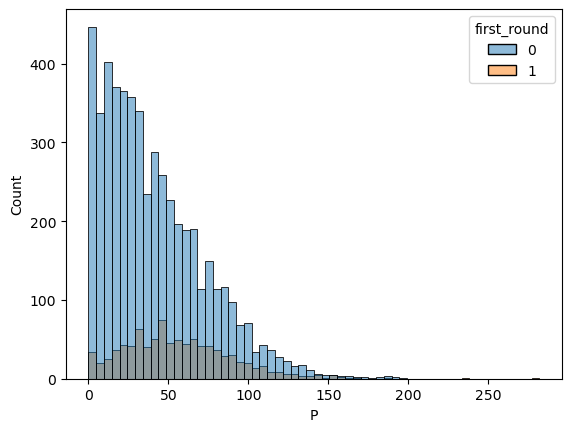

In [179]:
sns.histplot(x=players.P,hue=players.first_round)
plt.show()
plt.close()

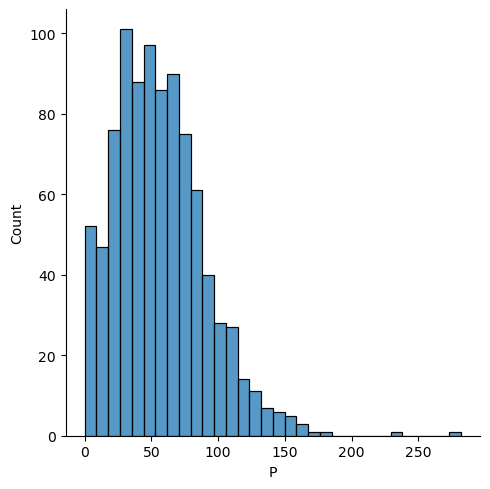

In [180]:
#Before I move on I want to look at the distributions of points for first round picks to check for outliers 
# as these will limit our model performance

first_round_players=players.loc[players['first_round'] == 1]
sns.displot(first_round_players.P)
plt.show()
plt.close()

#There are far too many points around zero. Lets take a closer look


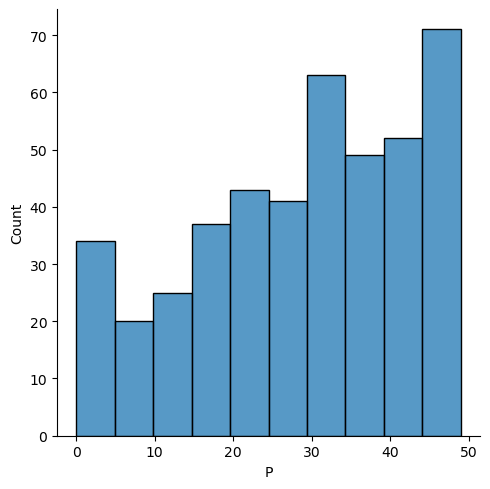

In [181]:
first_round_players=first_round_players.loc[first_round_players['P'] < 50]
sns.displot(first_round_players.P)
plt.show()
plt.close()

#Some of this data could be accurate, but first round picks who had less than 50 points in their last junior season is concerning

In [182]:
first_round_players=first_round_players.loc[first_round_players['P'] < 50]
first_round_players.head()

#We see that the stats for these players do not make much sense and are actually wrong

,year,overall_pick,team,player,nationality,position,amateur_team,G,A,GP,PIM,LEAGUE,P,start_year,first_round
39,2021-01-01,32,Chicago Blackhawks,Nolan Allan,CA,D,Prince Albert Raiders (WHL),0.0,1.0,7.0,2.0,WHL,1.0,2018-01-01,1
47,2021-01-01,29,New Jersey Devils,Chase Stillman,US,RW,Sudbury Wolves (OHL),6.0,2.0,8.0,0.0,NOJHL,8.0,2018-01-01,1
49,2021-01-01,2,Seattle Kraken,Matthew Beniers,US,C,Michigan (Big Ten),11.0,20.0,33.0,12.0,USHL,31.0,2018-01-01,1
50,2021-01-01,5,Columbus Blue Jackets,Kent Johnson,CA,C,Michigan (Big Ten),20.0,26.0,57.0,24.0,BCHL,46.0,2018-01-01,1
51,2021-01-01,9,Arizona Coyotes,Dylan Guenther,CA,RW,Edmonton Oil Kings (WHL),3.0,1.0,8.0,0.0,WHL,4.0,2018-01-01,1


In [183]:
first_round_players.shape

(435, 15)

I think its fair to say that these 312 data points are outliers. From my own knowledge, I know Nolan Allen had more than 1 point in his last season of the WHL. This is an issue with the data sets. I will drop these outliers.

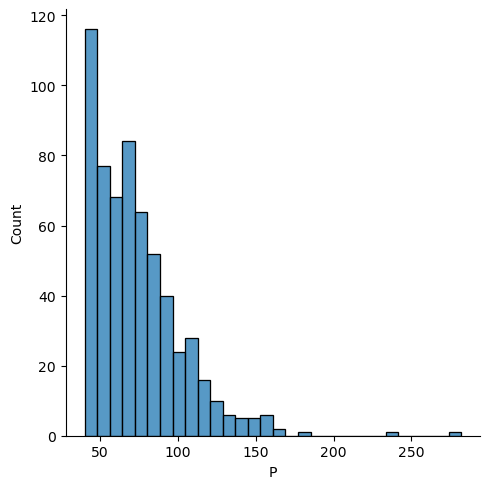

In [184]:
mask=(players['P'] < 40) & (players["first_round"] == 1)
players=players.drop(players[mask].index)

first_round_players=players.loc[players['first_round'] == 1]
sns.displot(first_round_players.P)
plt.show()
plt.close()

#This looks much better


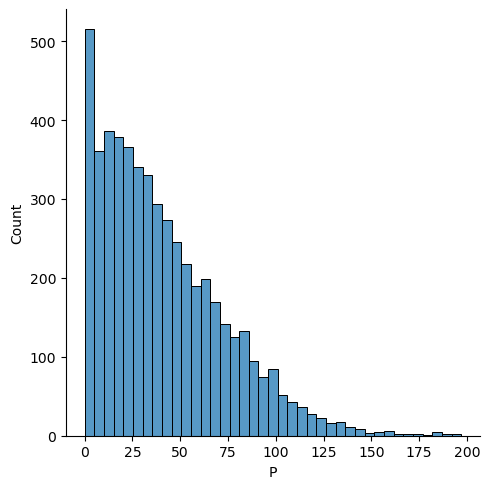

In [185]:
#Now, lets do the same thing but for non-first round picks
non_firstRound=players.loc[players['first_round'] == 0]
sns.displot(non_firstRound.P)
plt.show()
plt.close()

#Wow, there is definitly some inacuracte data. Anyone scoring above 120 points is definitly a first round pick.

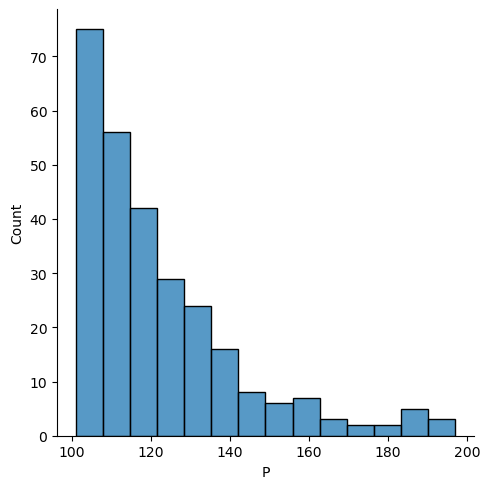

In [186]:
non_firstRound=non_firstRound.loc[non_firstRound['P'] > 100]
sns.displot(non_firstRound.P)
plt.show()
plt.close()

In [187]:
non_firstRound.shape

(278, 15)

Again, I think these datapoints are definetly wrong. Lets remove them

In [188]:
mask=(players['P'] > 100) & (players["first_round"] == 0)
players=players.drop(players[mask].index)

In [189]:
players.head()

,year,overall_pick,team,player,nationality,position,amateur_team,G,A,GP,PIM,LEAGUE,P,start_year,first_round
0,2022-01-01,145,Vegas Golden Knights,Patrick Guay,CA,C,Charlottetown Islanders (QMJHL),18.0,18.0,54.0,16.0,QMJHL,36.0,2018-01-01,0
1,2022-01-01,146,Nashville Predators,Graham Sward,CA,D,Spokane Chiefs (WHL),1.0,0.0,1.0,0.0,WHL,1.0,2018-01-01,0
2,2022-01-01,130,Montreal Canadiens,Jared Davidson,CA,C,Seattle Thunderbirds (WHL),2.0,2.0,48.0,22.0,WHL,4.0,2018-01-01,0
3,2022-01-01,114,Nashville Predators,Cole O'Hara,CA,RW,Tri-City Storm (USHL),11.0,31.0,53.0,24.0,OJHL,42.0,2018-01-01,0
4,2022-01-01,173,Chicago Blackhawks,Dominic James,US,C,Minnesota-Duluth (NCHC),0.0,0.0,2.0,2.0,USHL,0.0,2018-01-01,0


In [190]:
#I plan to build a classification model. I will need to drop the string features or create dumby variables

#Lets drop year, team, player, and start-year as they will not be needed

feature_cols=[ 'nationality',
       'position', 'amateur_team','G','A','GP','PIM','LEAGUE','P','first_round','year']

players=players[feature_cols]

In [191]:
print(players.position.unique())
print(players.position.nunique())

#This can be drastically simplified. I am going to make an assumption that the first position if there are tow listed (i.e C/LW) is 
# the players preferred position. I will convert the position to the first one listed

players.position=players.position.apply(lambda x: x.split('/')[0])
print(players.position.unique())

['C' 'D' 'RW' 'LW' 'C/LW' 'C RW' 'C; LW' 'C/RW' 'W' 'F' 'Centr' 'C/W'
 'C/D' 'D/LW' 'LW/D' 'RW/D' 'LW/C' 'RW/C' 'D/C']
19
['C' 'D' 'RW' 'LW' 'C RW' 'C; LW' 'W' 'F' 'Centr']


In [192]:
#We still have a few weird exceptions. Lets fix those
players.position=players.position.apply(lambda x: x.split(';')[0])
players.position=players.position.apply(lambda x: x.split(' ')[0])
print(players.position.unique())

['C' 'D' 'RW' 'LW' 'W' 'F' 'Centr']


In [193]:
#Lets make all Wingers equal to Right Wingers. All L equal to Left wingers and all F equal to centres
players.position=np.where(players.position == 'W','RW',players.position)
players.position=np.where(players.position == 'Centr','C',players.position)
players.position=np.where(players.position == 'F','C',players.position)
print(players.position.unique())

['C' 'D' 'RW' 'LW']


In [194]:
#Out of curiousity lets look at the distribution of positions
players.position.value_counts(normalize=True).round(4)

#36% of draft picks are D and the rest are forwards... interesting

D     0.3705
C     0.2645
LW    0.1853
RW    0.1797
Name: position, dtype: float64

In [195]:
#Now lets look at amatuer team
print(players.amateur_team.nunique())
#Wow there are way to many and I do not think this is relevant. Lets drop it
players.drop(columns='amateur_team',inplace=True)

841


In [196]:
#Next, lets look at Nationality
print(players.nationality.nunique())
print(players.nationality.unique())

34
['CA' 'US' 'RU' 'AT' 'CZ' 'GB' 'FI' 'CH' 'SE' 'BY' 'SK' 'AU' 'DE' 'TH'
 'JM' 'NO' 'SI' 'LV' 'BE' 'UA' 'CN' 'NL' 'DK' 'FR' 'NG' 'JP' 'PL' 'ME'
 'YU' 'KZ' 'TZ' 'BN' 'KR' 'IT']


In [197]:
#Again, there are two many. However, most draft pics are from North America. Maybe we could group by a broader geography and not country
players.nationality.value_counts(normalize=True).reset_index().head()

#Regardless, I will drop this feature. The country a player comes from should not limit their hockey abilities; however, it could 
# limit their access to development growing up

players.drop(columns='nationality',inplace=True)

In [198]:
#Finally, I will look at leagues
print(players.LEAGUE.nunique())
print(players.LEAGUE.unique())

15
['QMJHL' 'WHL' 'OJHL' 'USHL' 'CCHL' 'AJHL' 'NCAA' 'MJHL' 'OHL' 'NOJHL'
 'MJAHL' 'BCHL' 'QJAAAHL' 'SJHL' 'SIJHL']


In [199]:
#Again, there are too many and I dont think they will impact draft status. Lets drop the column
players.drop(columns='LEAGUE',inplace=True)

In [200]:
#Now, I can create dummy variables for the position
players=pd.get_dummies(players)
players.head(3)

,G,A,GP,PIM,P,first_round,year,position_C,position_D,position_LW,position_RW
0,18.0,18.0,54.0,16.0,36.0,0,2022-01-01,1,0,0,0
1,1.0,0.0,1.0,0.0,1.0,0,2022-01-01,0,1,0,0
2,2.0,2.0,48.0,22.0,4.0,0,2022-01-01,1,0,0,0


Finally, lets look at the years in the data. Because of how much the game has changed in the last 30 years, I am only going to keep data from 1990 and onwards.

In [201]:
players=players[players.year > datetime.strptime('1990','%Y')]
players.head()

,G,A,GP,PIM,P,first_round,year,position_C,position_D,position_LW,position_RW
0,18.0,18.0,54.0,16.0,36.0,0,2022-01-01,1,0,0,0
1,1.0,0.0,1.0,0.0,1.0,0,2022-01-01,0,1,0,0
2,2.0,2.0,48.0,22.0,4.0,0,2022-01-01,1,0,0,0
3,11.0,31.0,53.0,24.0,42.0,0,2022-01-01,0,0,0,1
4,0.0,0.0,2.0,2.0,0.0,0,2022-01-01,1,0,0,0


### Outliers

I will use the z-score approach to remove any outliers. I will remove outliers in terms of games played as these are often injuries.

In [202]:
players.shape

(4007, 11)

In [203]:
z=np.abs(stats.zscore(players.GP))

players['GP_z_score']=z
Threshold = 2 
players=players[players.GP_z_score < Threshold]

players.shape

(3802, 12)

Now, lets do the same thing for points. I feel that a lot of the international data is innacurate

In [204]:
z=np.abs(stats.zscore(players.P))

players['P_z_score']=z
Threshold = 2 
players=players[players.P_z_score < Threshold]

players.shape

(3690, 13)

### Co-Linearity

We must check to see if any of the features are co-linear. This is an assumption that must be checked for machine learning models.

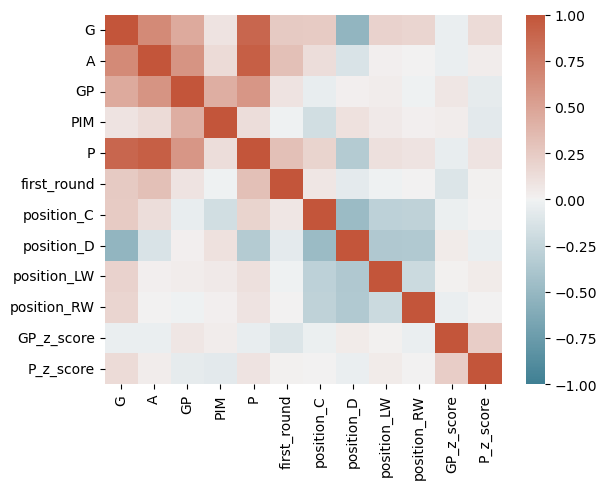

In [205]:
cor_matrix=players.corr()
red_blue = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(cor_matrix, vmin = -1, vmax = 1, cmap=red_blue)
plt.show()

 We see that A, G, and P are highly correlated. This makes sense - they are co-linear. Lets drop the points column

In [206]:
players.drop(columns='P',inplace=True)

### Class Balance

Another assumption we must check is class balance. ML Models require classes to be balanced

In [207]:
players.first_round.value_counts(normalize=True).round(4)

#9% of the data are first round picks. This makes sense as there are 7 rounds in the draft.

#Therefore, we must balance the class weights in the model

0    0.9003
1    0.0997
Name: first_round, dtype: float64

### Standardization

Using Scikit-Learn Pre-processing library, lets standardize the data so that the difference in scale does not impact our classification models.

A standard score is the value less the mean and divided by the standard deviation. It centralizes the data with a mean at 0 and scales it by the STD

In [208]:
#Now lets split up into x and y 
players.drop(columns='year',inplace=True)
y=players.first_round
x=players.drop(columns={'first_round','GP_z_score','P_z_score'})
x.head()

,G,A,GP,PIM,position_C,position_D,position_LW,position_RW
0,18.0,18.0,54.0,16.0,1,0,0,0
2,2.0,2.0,48.0,22.0,1,0,0,0
3,11.0,31.0,53.0,24.0,0,0,0,1
5,5.0,13.0,47.0,85.0,0,1,0,0
9,24.0,30.0,51.0,16.0,1,0,0,0


In [209]:
#Lets scale the data
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
x_titles=x.columns.tolist()
x_not_scaled=x
x_scaled=scale.fit_transform(x)
x=pd.DataFrame(data=x_scaled,columns=x_titles)
x.head(2)

,G,A,GP,PIM,position_C,position_D,position_LW,position_RW
0,0.219011,-0.468028,0.301030,-0.923558,1.626728,-0.779194,-0.464559,-0.453308
1,-1.132554,-1.545018,-0.108608,-0.808941,1.626728,-0.779194,-0.464559,-0.453308


# Feature Engineering

## PCA

PCA (Principal Component Analysis):

PCA is an unsupervised ML algorithm that allows us to reduce the number of features that we have without loosing any of the information of the dataset.

PCA algorithms calculate a covariance matrix to show the relationship between each feature. We then use matrix factorization to find a pair of matrices that equal the covariance matrix, hence reducing the features without losing information. To do this, we use eigenvectors and eigenvalues to rotate a n-dimensional space to a 2-dimensional space.

To demonstrate my understanding, I will build a PCA algorithm before using scikit-learn model

### PCA Algorithm

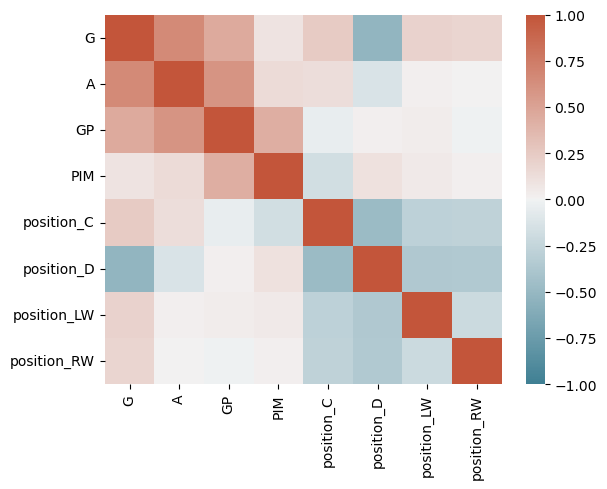

In [210]:
#Lets look at the correlation matrix
cor_matrix=x.corr()
red_blue = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(cor_matrix, vmin = -1, vmax = 1, cmap=red_blue)
plt.show()

In [211]:
#Now lets get the eigenvalues and eigenvectors
eigenvalues ,eigenvectors =np.linalg.eig(cor_matrix)

In [212]:
# Find the proportion of information for each eigenvector, which is equal to the eigenvalues divided by the sum of all eigenvalues
info_prop = eigenvalues/eigenvalues.sum()

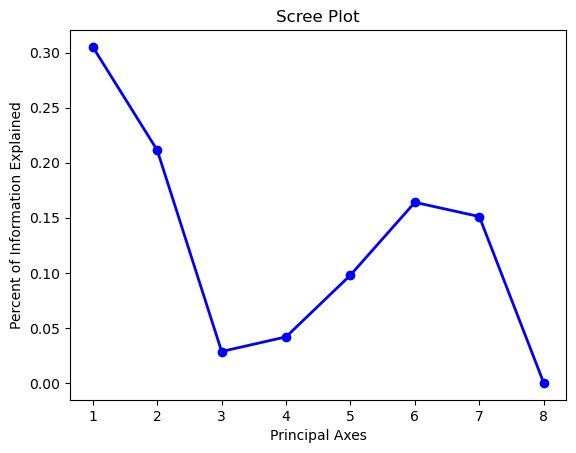

In [213]:
#Make a Scee plot to see how the percent of information explained changes with the number of features
plt.plot(np.arange(1,len(info_prop)+1),info_prop, 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Axes')
plt.xticks(np.arange(1,len(info_prop)+1))
plt.ylabel('Percent of Information Explained')
plt.show()
plt.close()

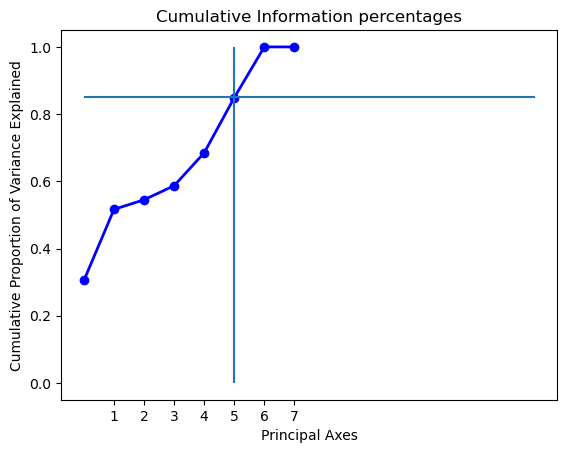

In [214]:
#What about the cumulative sum of the proportions
cum_info_prop = np.cumsum(info_prop)


plt.plot(cum_info_prop, 'bo-', linewidth=2)
plt.hlines(y=.85, xmin=0, xmax=15)
plt.vlines(x=5, ymin=0, ymax=1)
plt.title('Cumulative Information percentages')
plt.xlabel('Principal Axes')
plt.xticks(np.arange(1,len(info_prop)))
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()
plt.close()

#From this, we see that we need 6 features to explain 85% of the variance in the data.
#We may be able to drop the last 2 featrues to reduce computation time

In [215]:
cum_info_prop=np.reshape(cum_info_prop,(1,8))
cum_info_prop= pd.DataFrame(columns=x_titles,data=cum_info_prop)
cum_info_prop

#It looks like position explians no variance in the data

,G,A,GP,PIM,position_C,position_D,position_LW,position_RW
0,0.305182,0.516534,0.54507,0.586912,0.684866,0.848903,1.0,1.0


### Using Scikit-Learn

In [216]:
from sklearn.decomposition import PCA

pca=PCA()

In [217]:
#The data is already standardized so we can find the principal components just like the algorithm did
components = pca.fit(x).components_
components = pd.DataFrame(components).transpose()
components.index = x.columns

In [218]:
#Then we need to calculate the variance and info proportion
var_ratio = (pca.explained_variance_ratio_*100).round(2)
var_ratio= pd.DataFrame(data=np.reshape(var_ratio,(1,8)),columns=x_titles)
var_ratio
#We see similar results... no variation is explained by the position of the player... interesting

,G,A,GP,PIM,position_C,position_D,position_LW,position_RW
0,30.52,21.14,16.4,15.11,9.8,4.18,2.85,0.0


Overall, the PCA revealed that 6 features will explian 95% variation in the data. The players postion is not needed.

## Wrapper Methods

A wrapper method for is an algorithm that selects features by evaluating the performance of a machine learning model on different subsets of features. These algorithms add or remove features one at a time based on how useful those features are to the model. I will look at sequential forward and backwards feature selection with and without replacement and recursive feature selection.

I will use a simple logistic regression model to determine the number of features needed

### Sequential Forward Selection

In [219]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

lr=LogisticRegression(class_weight='balanced')

c:\Users\eobri\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eobri\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


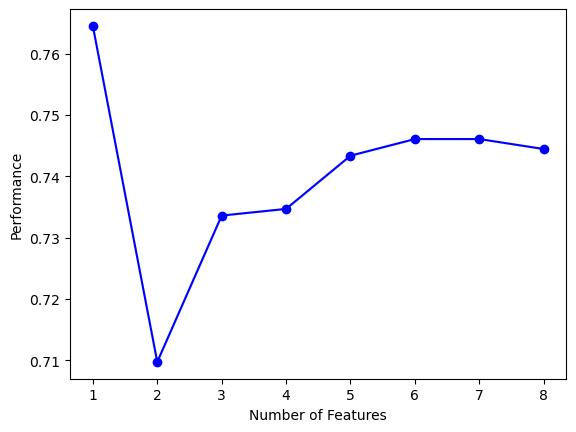

In [220]:
sfs = SFS(lr,k_features=len(x.columns),forward=True,floating=False,scoring='accuracy',cv=0)
sfs.fit(x, y)

# Plot the model accuracy
plot_sfs(sfs.get_metric_dict())
plt.show()
plt.close()

#We see the model performs best with 6 features

In [221]:
#What is the accuracy at 5 features?

print(sfs.subsets_[5]['avg_score'].round(4))

0.7434


Now, lets do SFS but with floating selection. This means that each time we add a feature we will check if removing one improves the performance

c:\Users\eobri\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eobri\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


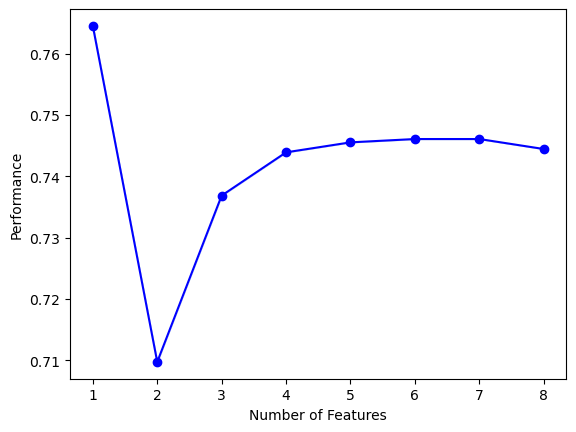

In [222]:
sfs = SFS(lr,k_features=len(x.columns),forward=True,floating=True,scoring='accuracy',cv=0)
sfs.fit(x, y)

# Plot the model accuracy
plot_sfs(sfs.get_metric_dict())
plt.show()
plt.close()

#Again, we see that 6 features result in the best performance

In [223]:
#Those features are:
print(sfs.subsets_[6]['feature_names'])
#With accuracy:
print(sfs.subsets_[6]['avg_score'].round(4))

#Interesting features chosen. We see that the model actually performs best with the positioning

('G', 'A', 'GP', 'position_C', 'position_D', 'position_LW')
0.7461


### Sequential Backward Selection

c:\Users\eobri\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eobri\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


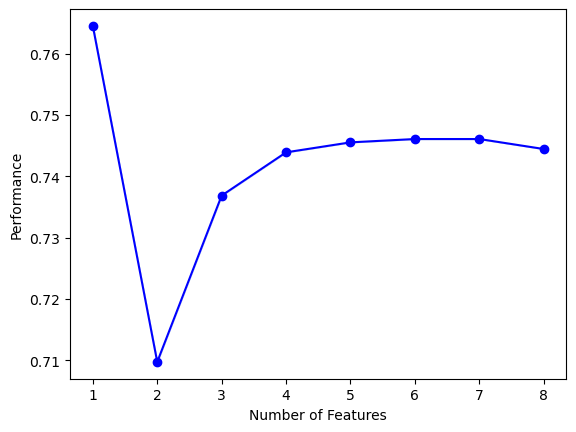

In [224]:
lr = LogisticRegression(class_weight='balanced')

# Sequential backward selection. Lets do floating
sbs = SFS(lr,k_features=len(x.columns),forward=True,floating=True,scoring='accuracy',cv=0)
sbs.fit(x, y)

plot_sfs(sbs.get_metric_dict())
plt.show()
plt.close()

#Looks pretty similar to the forward selection

In [225]:
#Those features are:
print(sbs.subsets_[6]['feature_names'])
#With accuracy:
print(sbs.subsets_[6]['avg_score'].round(4))

#We get the same results

('G', 'A', 'GP', 'position_C', 'position_D', 'position_LW')
0.7461


### Recursive Feature Selection

Recursive feature elimination is another wrapper method for feature selection. It starts by training a model with all available features. It then ranks each feature according to an importance metric and removes the least important feature. The algorithm then trains the model on the smaller feature set, ranks those features, and removes the least important one. The process stops when the desired number of features is reached.

I will use 6 features as the chosen amount since the PCA showed that 6 features explains 95% of the variance

In [226]:
from sklearn.feature_selection import RFE

feature_list = list(x.columns)

lr = LogisticRegression(max_iter=1000,class_weight='balanced')

# Recursive feature elimination
rfe = RFE(estimator=lr, n_features_to_select=6)
rfe.fit(x, y)

RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    n_features_to_select=6)

In [227]:
# List of features chosen by recursive feature elimination

rfe_features = [f for (f, support) in zip(feature_list, rfe.support_) if support]

print(rfe_features)

# Print the accuracy of the model with features chosen by recursive feature elimination
print(rfe.score(x,y).round(4))

#Interesting... we get different results from the SFS and SBF. Lets use these columns moving forward as intuetly they make more sense

['G', 'A', 'GP', 'PIM', 'position_D', 'position_LW']
0.7444


# Machine Learning Models

Overall, the SFS and SBS floating selection revealed that 6 features was needed for optimal model performance. The Recursive selection algorithms chose features that intuetively makes more sense to me. hence I will choose them.

Moving forward, I will look at the features ['A', 'GP', 'PIM', 'P', 'position_D']

In [228]:
selected_features=['G', 'A', 'GP', 'PIM', 'position_D', 'position_LW']
x=x[selected_features]
x.head()

,G,A,GP,PIM,position_D,position_LW
0,0.219011,-0.468028,0.301030,-0.923558,-0.779194,-0.464559
1,-1.132554,-1.545018,-0.108608,-0.808941,-0.779194,-0.464559
2,-0.372299,0.407027,0.232757,-0.770736,-0.779194,-0.464559
3,-0.879136,-0.804587,-0.176881,0.394539,1.283378,-0.464559
4,0.725848,0.339715,0.096211,-0.923558,-0.779194,-0.464559


I will aim to classify if a player is drafted in the first round or not using a logistic regression, K Nearest Neighbours, Descision Tree, SVM, and Naive Bayers Classification model

In [229]:
#First, lets split the data into training and testing datasets

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

## Logistic Regression

Logistic regressions are similar to a linear regression except it is used to predict a binary output. It uses log-odds or a sigmoid function to compute probabilities of a data point falling within a class. Based on some threshold it then classifies the point as 0 or 1. 

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
#Logistic regression object using scikit-learn library
lr=LogisticRegression(class_weight='balanced')
#train the model using the data
lr.fit(x_train,y_train)


LogisticRegression(class_weight='balanced')

In [231]:
#Check the performance
y_pred=lr.predict(x_test)

print(f'accruacy: {lr.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred))

accruacy: 0.7304
Confusion Matrix: 
[[490 183]
 [ 16  49]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       673
           1       0.21      0.75      0.33        65

    accuracy                           0.73       738
   macro avg       0.59      0.74      0.58       738
weighted avg       0.90      0.73      0.79       738



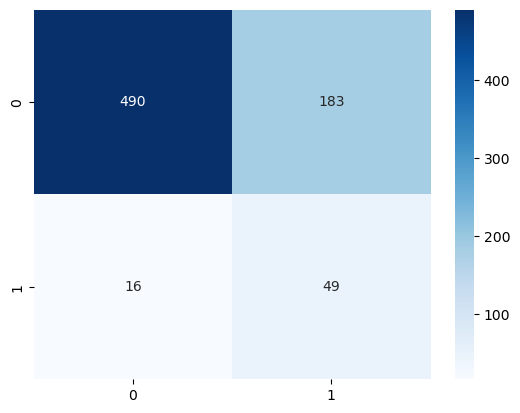

In [232]:
conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Show the plot
plt.show()

## K Nearest Neighbours

This model works by assuming data of the same class will be close to eachother. It uses the distance formula to determine how close an item is to other items of a known class. Then, using k, or the number of closest neighbours to assess, it classifies the point based on majority rules of what class of points are closest to it. Generally, a k of around 5 is acceptable

In [233]:
from sklearn.neighbors import KNeighborsClassifier
#K nearest neighbours object using scikit-learn library
class_weight = {0: 1, 1: 10}
k_neigh = KNeighborsClassifier(n_neighbors=5, weights='distance' )
#Train the model
k_neigh.fit(x_train,y_train)

KNeighborsClassifier(weights='distance')

In [234]:
y_pred=k_neigh.predict(x_test)

print(f'accruacy: {k_neigh.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred))

accruacy: 0.8916
Confusion Matrix: 
[[650  23]
 [ 57   8]]
classification report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       673
           1       0.26      0.12      0.17        65

    accuracy                           0.89       738
   macro avg       0.59      0.54      0.55       738
weighted avg       0.86      0.89      0.87       738



These results are great... however, because the class weights are imbalanced, the data is overfit to the nagative class.

## Decision Tree

A decision tree is another classification model that looks at patterns in a dataset and breaks down data feature by feature to classify. 

The tree keeps splitting to lower the gini impurity (1 - sum of squared probabilties) to increase the information gain

In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#Max depth at 3 so not to overfit the data
dTree= DecisionTreeClassifier(max_depth=7,class_weight='balanced')

In [236]:
#Again, we will look at the performance
dTree.fit(x_train,y_train)
y_pred= dTree.predict(x_test)
print(f'accruacy: {dTree.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))



accruacy: 0.706
Confusion Matrix: 
[[467 206]
 [ 11  54]]
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       673
           1       0.21      0.83      0.33        65

    accuracy                           0.71       738
   macro avg       0.59      0.76      0.57       738
weighted avg       0.91      0.71      0.77       738



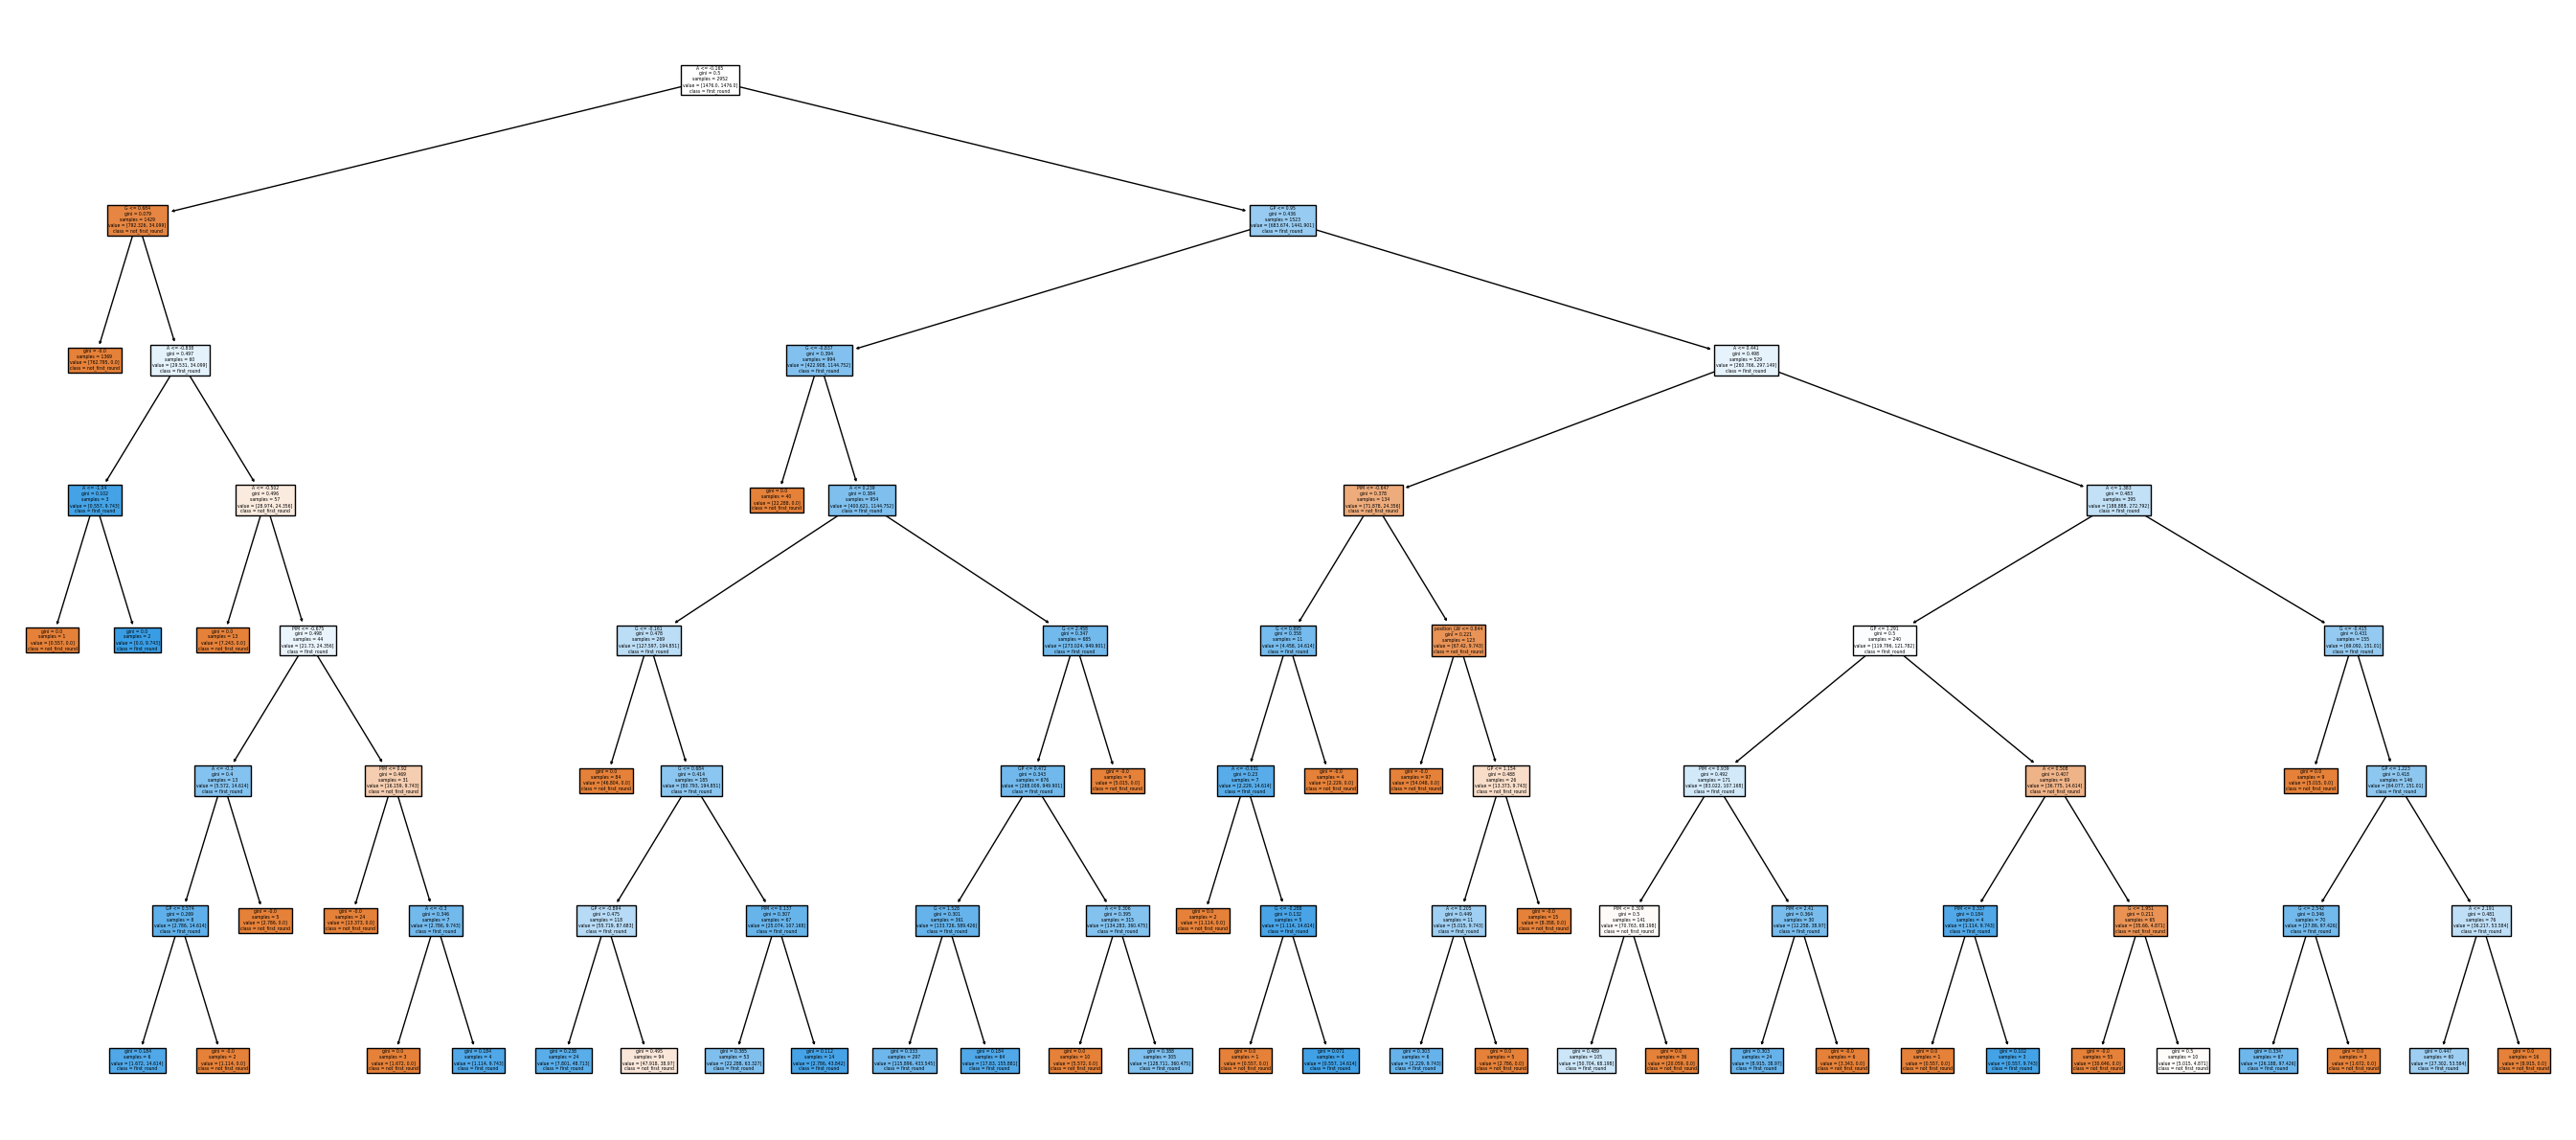

In [237]:
#Lets visualize the tree
plt.figure(figsize=(27,12))
tree.plot_tree(dTree,feature_names =x_train.columns,class_names=['not_first_round','first_round'],filled=True)
plt.tight_layout()
plt.show()

## Support Vector Machines (SVM)

SVM's work by defining a decision boundary and making a classification based off of which side of the boundary the point falls on.

This model has high computational speed as we only are worried about the points on the decision boundary margin. I will use a RBF kernal 

In [238]:
from sklearn.svm import SVC

svc=SVC(kernel = "rbf", gamma = 1, C = 1,class_weight='balanced')

svc.fit(x_train,y_train)

SVC(C=1, class_weight='balanced', gamma=1)

In [239]:
#Again, we will look at the performance
y_pred= svc.predict(x_test)
print(f'accruacy: {svc.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred))

#We will need to tune the model to find the ideal C and gamma. I will do that later

accruacy: 0.7358
Confusion Matrix: 
[[492 181]
 [ 14  51]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       673
           1       0.22      0.78      0.34        65

    accuracy                           0.74       738
   macro avg       0.60      0.76      0.59       738
weighted avg       0.91      0.74      0.79       738



# Ensemble Methods

We have used 4 different classification models to predict if a player will be drafted in the first round of the NHL draft. Below are the resulting model accuracies.

- LR: 73.04%

- KN: 89.7%

- DTree: 70.60%

- SVM: 73.58%

Although the KNN method returned the highest accuracy, it was extremely overfitted to the negative class. This is because the dataset has a class imbalance (9% class=1) and so this method must be ignored.

Therefore, I will attempt to improve the perforamcne of the other models using various ensemble methods.


## Random Forests

I will use the random forests ensemble method on the Decision Tree model from the previous section of my analsysis.

A random forest contains many decision trees that all work together to classify new points. The default is 100 classifiers, and each of those trees reports their classification and the random forest returns the most popular classification.

The random forest uses bootstrapping, meaning that each time a decision tree makes a classification it uses a random subset from the dataset. 

In [240]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor

rf=RandomForestClassifier(bootstrap=True,max_depth=7,n_estimators=10,class_weight='balanced')
rf.fit(x_train,y_train)
print(rf.get_params())
y_pred=rf.predict(x_test)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [241]:
y_pred= rf.predict(x_test)
print(f'accruacy: {rf.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred))

#We improved the model by 3%!!!

accruacy: 0.7398
Confusion Matrix: 
[[498 175]
 [ 17  48]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       673
           1       0.22      0.74      0.33        65

    accuracy                           0.74       738
   macro avg       0.59      0.74      0.59       738
weighted avg       0.90      0.74      0.79       738



## Bagging

The Random Forests ensemble method is a form of Bootstrap Aggregation or `Bagging`. It uses many classifiers each drawing on random subsets of the data and aggregates the results to find the most common classification. I will using the scikit-learn bagging classifier to try to improve both the Decision tree and SVM models

In [242]:
from sklearn.ensemble import BaggingClassifier

bagging_DTree=BaggingClassifier(DecisionTreeClassifier(max_depth=7,class_weight='balanced'),n_estimators=100)
bagging_DTree.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        max_depth=7),
                  n_estimators=100)

In [243]:
y_pred= bagging_DTree.predict(x_test)
print(f'accruacy: {bagging_DTree.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))

#We see a bigger accuracy improvement using the bagging method. Improvement by 4.2%

accruacy: 0.748
Confusion Matrix: 
[[503 170]
 [ 16  49]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.75      0.84       673
           1       0.22      0.75      0.35        65

    accuracy                           0.75       738
   macro avg       0.60      0.75      0.59       738
weighted avg       0.90      0.75      0.80       738



We see that we were able to improve the models accuracy. Now lets implement the same with the SVM model

In [244]:
bagging_SVM=BaggingClassifier(SVC(kernel = "rbf", gamma = 1, C = 10,class_weight='balanced'),n_estimators=100)
bagging_SVM.fit(x_train,y_train)

BaggingClassifier(base_estimator=SVC(C=10, class_weight='balanced', gamma=1),
                  n_estimators=100)

In [245]:
y_pred= bagging_SVM.predict(x_test)
print(f'accruacy: {bagging_SVM.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred))

#We improved accuracy by almost 10%... WOW!!!

accruacy: 0.8144
Confusion Matrix: 
[[565 108]
 [ 29  36]]
classification report: 
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       673
           1       0.25      0.55      0.34        65

    accuracy                           0.81       738
   macro avg       0.60      0.70      0.62       738
weighted avg       0.89      0.81      0.84       738



Now with the LR

In [246]:
bagging_lr=BaggingClassifier(LogisticRegression(class_weight='balanced'),n_estimators=10)
bagging_lr.fit(x_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'))

In [247]:
y_pred= bagging_lr.predict(x_test)
print(f'accruacy: {bagging_lr.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred))

#The accuracy improved slightly

accruacy: 0.7304
Confusion Matrix: 
[[491 182]
 [ 17  48]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       673
           1       0.21      0.74      0.33        65

    accuracy                           0.73       738
   macro avg       0.59      0.73      0.58       738
weighted avg       0.90      0.73      0.79       738



## Boosting

Boosting is a sequential learning technique where each of the base models is a weak learner and builds off of the previous model. Each subsequent model aims to improve the performance of the final ensemble model by attempting to fix the errors in the previous stage.

There are two types of boosting methods: Adaptive Boosting and Gradient Boosting.

AdaBoost (Adaptive Boosting) is a sequential method where each base model is reweighted to reduce error. I will use adaptive boosting for the decision tree and SVM model

### AdaBoost

In [248]:
from sklearn.ensemble import AdaBoostClassifier

decision_stump=DecisionTreeClassifier(max_depth=1,class_weight='balanced')
ada_classifier=AdaBoostClassifier(base_estimator =decision_stump,n_estimators=5)
ada_classifier.fit(x_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   n_estimators=5)

In [249]:
y_pred= ada_classifier.predict(x_test)
print(f'accruacy: {ada_classifier.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))

#The model perforamnce actually decreased!

accruacy: 0.6558
Confusion Matrix: 
[[432 241]
 [ 13  52]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.64      0.77       673
           1       0.18      0.80      0.29        65

    accuracy                           0.66       738
   macro avg       0.57      0.72      0.53       738
weighted avg       0.90      0.66      0.73       738



In [250]:
svc_boost=SVC(kernel = "rbf", gamma = 1, C = 20,class_weight='balanced')
ada_classifier=AdaBoostClassifier(base_estimator =svc_boost,n_estimators=5,algorithm='SAMME')
ada_classifier.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SVC(C=20, class_weight='balanced', gamma=1),
                   n_estimators=5)

In [251]:
y_pred= ada_classifier.predict(x_test)
print(f'accruacy: {accuracy_score(y_test,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))



accruacy: 0.9119
Confusion Matrix: 
[[673   0]
 [ 65   0]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       673
           1       0.00      0.00      0.00        65

    accuracy                           0.91       738
   macro avg       0.46      0.50      0.48       738
weighted avg       0.83      0.91      0.87       738



We see a massive increase in accuracy, however the data is results of extremely unbalanced. None of the positive classes were correctly predicted. We must discard this model.

In [252]:
lr_boost=LogisticRegression(class_weight='balanced')
ada_classifier=AdaBoostClassifier(base_estimator =lr_boost,n_estimators=5)
ada_classifier.fit(x_train,y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                   n_estimators=5)

In [253]:
y_pred= ada_classifier.predict(x_test)
print(f'accruacy: {accuracy_score(y_test,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))

#The model accuracy decreased, but the precision increased

accruacy: 0.7127
Confusion Matrix: 
[[485 188]
 [ 24  41]]
classification report: 
              precision    recall  f1-score   support

           0       0.95      0.72      0.82       673
           1       0.18      0.63      0.28        65

    accuracy                           0.71       738
   macro avg       0.57      0.68      0.55       738
weighted avg       0.88      0.71      0.77       738



### Gradient Boost

Gradient Boosting fits a base model to the negative gradient of the error in the previous stage. So the second model will calculate the residuals of the previous model and determine the weighting of parameters. I will only use this for Decision Tree model

In [254]:
from sklearn.ensemble import GradientBoostingClassifier

grad_classifier=GradientBoostingClassifier(n_estimators =10)

grad_classifier.fit(x_train,y_train)


GradientBoostingClassifier(n_estimators=10)

In [255]:
y_pred= grad_classifier.predict(x_test)
print(f'accruacy: {accuracy_score(y_test,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))

#No change in accuracy

accruacy: 0.9119
Confusion Matrix: 
[[673   0]
 [ 65   0]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       673
           1       0.00      0.00      0.00        65

    accuracy                           0.91       738
   macro avg       0.46      0.50      0.48       738
weighted avg       0.83      0.91      0.87       738



We see a massive increase in accuracy, however the data is results of extremely unbalanced. None of the positive classes were correctly predicted. We must discard this model.

# Hyperparamater Tuning

After the various ensemble methods and then disregarding the unbalanced models with high accuracys, I can conclude that the Bagging SVM and the Bagging DT were the most accurate models.

- SVM: 81.44%

- Bagging DT: 74.8%

I will now use Hyperparameter tuning to further improve model accuracy. I will use lasso and ridge regularization and attempt to find the optimal paramters for all types of models. 

Lasso is a shrinkage feature selection method and ridge focuses on multicolinearity



## SVM

In [256]:
from sklearn.model_selection import GridSearchCV

parameters = { 'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
svc=SVC(kernel = "rbf",class_weight='balanced')

clf=GridSearchCV(svc,parameters,refit=True,verbose=2,scoring='accuracy')

clf.fit(x_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.4s
[CV] END .....................................C=0.1, gamma=1; total time=   0.4s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.4s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             scoring='accuracy', verbose=2)

In [257]:
df = pd.concat([pd.DataFrame(clf.cv_results_['params']), pd.DataFrame(clf.cv_results_['mean_test_score'], columns=['Accuracy'])] ,axis=1)

# This table displays the information more clearly.
cv_table = df.pivot(index = 'C', columns = 'gamma')
print(cv_table)

       Accuracy                              
gamma     0.001     0.010     0.100     1.000
C                                            
0.1    0.648362  0.692745  0.673431  0.687658
1.0    0.701892  0.693078  0.686641  0.739831
10.0   0.715103  0.691727  0.701218  0.782852
100.0  0.708667  0.687661  0.713749  0.809962


In [258]:
print(clf.best_estimator_)

SVC(C=100, class_weight='balanced', gamma=1)


In [259]:
svc=SVC(gamma=1,C=100,kernel='rbf',class_weight='balanced')
svc.fit(x_train,y_train)

SVC(C=100, class_weight='balanced', gamma=1)

In [260]:
y_pred= svc.predict(x_test)
print(f'accruacy: {svc.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))

accruacy: 0.8117
Confusion Matrix: 
[[569 104]
 [ 35  30]]
classification report: 
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       673
           1       0.22      0.46      0.30        65

    accuracy                           0.81       738
   macro avg       0.58      0.65      0.60       738
weighted avg       0.88      0.81      0.84       738



## Bagging DT

In [261]:
parameters = {  'criterion' :['gini', 'entropy'], 'max_depth': [1,2,3,4,5,6,7]}
dTree=DecisionTreeClassifier(class_weight='balanced')

clf=GridSearchCV(dTree,parameters,refit=True,verbose=2)

clf.fit(x_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini,

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7]},
             verbose=2)

In [262]:
df = pd.concat([pd.DataFrame(clf.cv_results_['params']), pd.DataFrame(clf.cv_results_['mean_test_score'], columns=['Accuracy'])] ,axis=1)

# This table displays the information more clearly.
cv_table = df.pivot(index = 'criterion', columns = 'max_depth')
print(cv_table)

           Accuracy                                                    \
max_depth         1         2         3         4         5         6   
criterion                                                               
entropy    0.581959  0.584679  0.633477  0.643966  0.708321  0.700200   
gini       0.581959  0.584679  0.644657  0.679527  0.689007  0.693746   

                     
max_depth         7  
criterion            
entropy    0.709011  
gini       0.715084  


In [263]:
print(clf.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', max_depth=7)


In [264]:
dTree=DecisionTreeClassifier(max_depth=7,criterion='gini',class_weight='balanced')
dTree.fit(x_train,y_train)
y_pred= dTree.predict(x_test)
print(f'accruacy: {dTree.score(x_test,y_test).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_pred,y_test))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))



accruacy: 0.7046
Confusion Matrix: 
[[466  11]
 [207  54]]
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       673
           1       0.21      0.83      0.33        65

    accuracy                           0.70       738
   macro avg       0.59      0.76      0.57       738
weighted avg       0.91      0.70      0.77       738



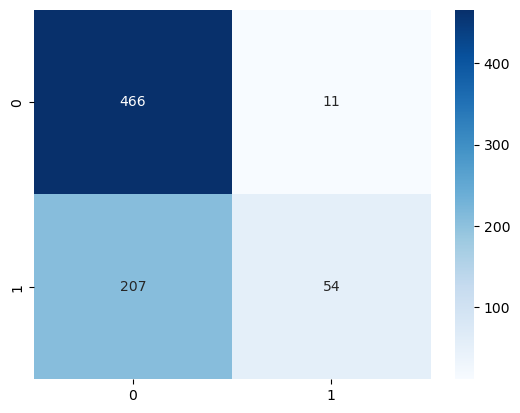

In [265]:
conf_matrix=confusion_matrix(y_pred,y_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Show the plot
plt.show()

# Deep Learning

## Sequential Model

In [273]:
import tensorflow as tf
input_shape=len(x_train.columns)
total_samples = x_train.shape[0]
weight_for_class_1 = total_samples / (total_samples * 0.1)
weight_for_class_0 = total_samples / (total_samples * 0.9)
class_weights = {0: weight_for_class_0, 1: weight_for_class_1}



In [282]:
# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape, )),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test), class_weight=class_weights)


Epoch 1/20
47/47 [==============================] - 2s 11ms/step - loss: 1.2855 - accuracy: 0.7334 - val_loss: 0.6085 - val_accuracy: 0.6599
Epoch 2/20
47/47 [==============================] - 0s 7ms/step - loss: 1.1393 - accuracy: 0.6850 - val_loss: 0.5845 - val_accuracy: 0.6423
Epoch 3/20
47/47 [==============================] - 0s 7ms/step - loss: 1.0694 - accuracy: 0.6836 - val_loss: 0.5533 - val_accuracy: 0.6477
Epoch 4/20
47/47 [==============================] - 0s 6ms/step - loss: 1.0100 - accuracy: 0.6961 - val_loss: 0.5338 - val_accuracy: 0.6545
Epoch 5/20
47/47 [==============================] - 0s 6ms/step - loss: 0.9744 - accuracy: 0.6860 - val_loss: 0.5325 - val_accuracy: 0.6450
Epoch 6/20
47/47 [==============================] - 0s 7ms/step - loss: 0.9491 - accuracy: 0.6921 - val_loss: 0.5249 - val_accuracy: 0.6477
Epoch 7/20
47/47 [==============================] - 0s 9ms/step - loss: 0.9437 - accuracy: 0.6850 - val_loss: 0.5330 - val_accuracy: 0.6382
Epoch 8/20
47/47 [=

In [283]:

# Make predictions on new data
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

24/24 [==============================] - 0s 2ms/step


In [284]:

print(f'accruacy: {accuracy_score(y_test,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_pred,y_test))
print('classification report: ')
print(classification_report(y_test,y_pred,zero_division=0))

accruacy: 0.6355
Confusion Matrix: 
[[408   4]
 [265  61]]
classification report: 
              precision    recall  f1-score   support

           0       0.99      0.61      0.75       673
           1       0.19      0.94      0.31        65

    accuracy                           0.64       738
   macro avg       0.59      0.77      0.53       738
weighted avg       0.92      0.64      0.71       738



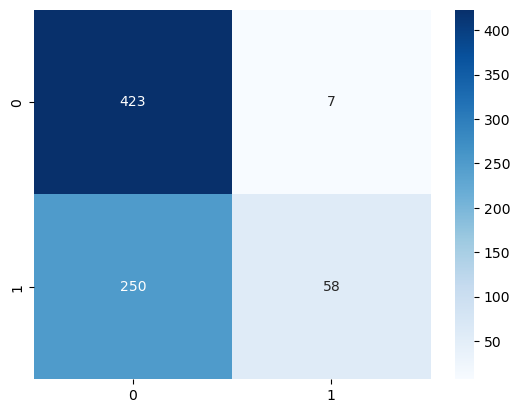

In [277]:
conf_matrix=confusion_matrix(y_pred,y_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Show the plot
plt.show()

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length))
model.add(tf.keras.layers.SimpleRNN(64, return_sequences=False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [279]:
x_train.head()

,G,A,GP,PIM,position_D,position_LW
1011,0.725848,-0.198780,-1.132702,-1.114587,-0.779194,2.152577
1178,0.134538,0.608963,-0.791337,0.088893,-0.779194,-0.464559
96,-0.710190,-0.804587,0.505849,-1.038176,1.283378,-0.464559
43,-1.132554,-1.073835,0.301030,-0.465090,1.283378,-0.464559
2592,-1.217027,-1.410394,-1.269248,-0.522398,1.283378,-0.464559


# Conclusion

The following analysis cleaned and pre-processed data on the NHL draft picks since the 1960s. It was a great exercise that demonstrated my python and ML abilities. To summarize, below are the model results:

Preliminary Models:
- LR: 73.04%
- KN: 89.7% (Unbalanced)
- DTree: 70.60%
- SVM: 73.58%

Ensemble Methods:
- Random Forests: 73.58%
- Bagging DTree: 74.8%
- Bagging SVM: 81.44%
- Bagging LR: 73.44%
- AdaBoost DTree: 65.58%
- AdaBoost SVM: 91.19% (Unbalanced)
- AdaBoost LR: 71.27%
- Gradient Boost DTree: 91.19% (Unbalanced)

Selected Parameters:
- SVM: C=100, gamma=1
- Bagging DT: max_depth=7, criterion='gini'

Therefore, the model has an accuracy of 81.44%

Selected Parameters:
- SVM: C=1, gamma=1
- Bagging DT: max_depth=5, criterion='entropy'

Overall, we can conclude that the two best models are the Bagging SVM and the Bagging Decision Tree. Both had mediocre accuracies at 81.44% and 74.8%, however had relatively high recall scores at 55% and 77%. The results are understandable as often the difference between a first round and a second round pick is not much.

Below is an example using the Bagging Decision Tree (it's quicker) to predict draft picks. 